# Figure 001 (v001)

Descriptive plots of the screen data.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask.dataframe as dd
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text

In [3]:
import speclet.plot as sp
from speclet.data_processing.vectors import squish_array
from speclet.io import DataFile, cache_dir, data_path, figure_img_file

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sp.set_speclet_theme(sp.PlottingMode.DISSERTATION)

In [5]:
FIGNUM, VERSION = 1, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "screen-data")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_001-v001/fig_001-v001_screen-data.png')

In [6]:
fig_cache = cache_dir() / f"figure-{FIGNUM}-v{VERSION}_cache"
if not fig_cache.exists():
    fig_cache.mkdir()

### Data

In [7]:
crispr_df = dd.read_csv(
    data_path(DataFile.DEPMAP_DATA),
    blocksize=25e7,
    low_memory=False,
    dtype={"age": "float64"},
).query("screen == 'broad'")
crispr_df.head(3)

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,lineage_subtype,primary_or_metastasis,is_male,age
86746,AAAGCCCAGGAGTATGGGAG,HEL-311Cas9_RepA_p4_batch3,0.858827,3,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,NaN,NaN,NaN,False,1.109223,blood,AML,NaN,True,30.0
86747,AAATCAGAGAAACCTGAACG,HEL-311Cas9_RepA_p4_batch3,-0.397664,3,chr11_89916950_-,TRIM49D1,broad,True,11,89916950,...,NaN,NaN,NaN,False,1.155134,blood,AML,NaN,True,30.0
86748,AACGTCTTTGAAGAAAGCTG,HEL-311Cas9_RepA_p4_batch3,0.102909,3,chr5_71055421_-,GTF2H2,broad,True,5,71055421,...,NaN,NaN,NaN,False,0.757424,blood,AML,NaN,True,30.0


## Descriptive statistics for text

In [8]:
gene_sgrna_map_fp = fig_cache / "gene_sgrna_map.csv"
if gene_sgrna_map_fp.exists():
    gene_sgrna_map = pd.read_csv(gene_sgrna_map_fp)
else:
    gene_sgrna_map = (
        crispr_df[["sgrna", "hugo_symbol"]]
        .drop_duplicates()
        .compute()
        .sort_values(["hugo_symbol", "sgrna"])
        .reset_index(drop=True)
    )
    gene_sgrna_map.to_csv(gene_sgrna_map_fp, index=False)

In [9]:
gene_sgrna_map.head()

,sgrna,hugo_symbol
0,GGAAGTCTGGAGTCTCCAGG,A1BG
1,GTGGACTTCCAGCTACGGCG,A1BG
2,GTGTGCCGAGGTGTGCTGCG,A1BG
3,TCAATGGTCACAGTAGCGCT,A1BG
4,GCAGATAAAACCAAAAACCG,A1CF


In [10]:
for col in ["sgrna", "hugo_symbol"]:
    n = gene_sgrna_map[col].nunique()
    print(f"num. unique values in '{col}': {n}")

num. unique values in 'sgrna': 71062
num. unique values in 'hugo_symbol': 18119


In [11]:
gene_sgrna_map.groupby("hugo_symbol").count().describe()

,sgrna
count,18119.000000
mean,3.921960
std,0.384721
min,1.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,11.000000


In [12]:
lineage_cell_map_fp = fig_cache / "lineage_cell_map.csv"
if lineage_cell_map_fp.exists():
    lineage_cell_map = pd.read_csv(lineage_cell_map_fp)
else:
    _cols = [
        "lineage",
        "lineage_subtype",
        "depmap_id",
        "primary_or_metastasis",
        "is_male",
        "age",
    ]
    lineage_cell_map = (
        crispr_df[_cols]
        .drop_duplicates()
        .compute()
        .sort_values(_cols)
        .reset_index(drop=True)
    )
    lineage_cell_map.to_csv(lineage_cell_map_fp, index=False)

In [13]:
lineage_cell_map.head()

,lineage,lineage_subtype,depmap_id,primary_or_metastasis,is_male,age
0,bile_duct,cholangiocarcinoma,ACH-000182,NaN,True,NaN
1,bile_duct,cholangiocarcinoma,ACH-000209,NaN,True,NaN
2,bile_duct,cholangiocarcinoma,ACH-000377,NaN,True,NaN
3,bile_duct,cholangiocarcinoma,ACH-000461,NaN,True,NaN
4,bile_duct,cholangiocarcinoma,ACH-000976,metastasis,True,NaN


In [14]:
for col in ["lineage", "lineage_subtype", "depmap_id"]:
    n = lineage_cell_map[col].nunique()
    print(f"num. unique values in '{col}': {n}")

num. unique values in 'lineage': 27
num. unique values in 'lineage_subtype': 77
num. unique values in 'depmap_id': 895


In [15]:
lineage_cell_map.groupby("primary_or_metastasis")["depmap_id"].count()

primary_or_metastasis
metastasis    274
primary       421
Name: depmap_id, dtype: int64

In [16]:
lineage_cell_map.groupby("is_male")["depmap_id"].count()

is_male
False    357
True     538
Name: depmap_id, dtype: int64

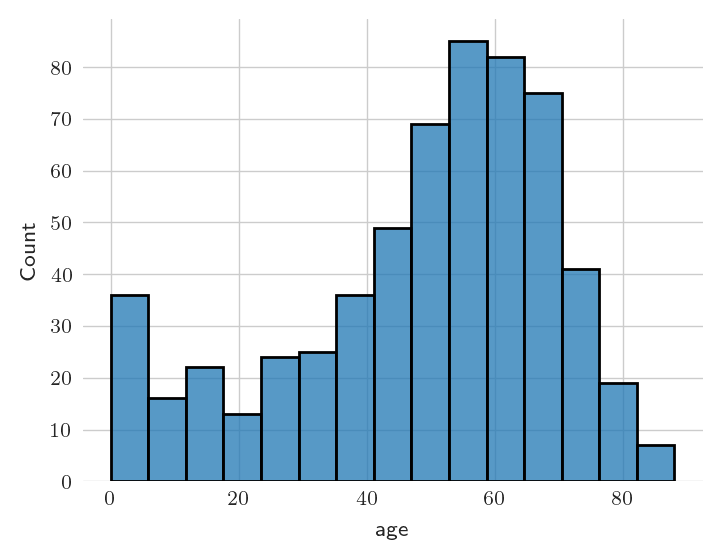

In [17]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(lineage_cell_map.dropna(subset=["age"]), x="age", ax=ax);

## Figure

### Shared

In [18]:
FIGSIZE = (6.5, 5)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=2, ncols=1, squeeze=True, height_ratios=(1.75, 1))

panel_a = subfigures[0]
second_row_panels = subfigures[1].subfigures(
    nrows=1, ncols=2, squeeze=True, width_ratios=(1, 1)
)
panel_b = second_row_panels[0]
panel_c = second_row_panels[1]

<Figure size 650x500 with 0 Axes>

### a. LFC per subtype and lineage

In [19]:
def _sample(df: pd.DataFrame) -> pd.DataFrame:
    return df.sample(n=min(100, len(df)), random_state=111)


crispr_df_sample_fp = fig_cache / "crispr_df_sample.csv"
if crispr_df_sample_fp.exists():
    crispr_df_sample = pd.read_csv(crispr_df_sample_fp)
else:
    crispr_df_sample = (
        crispr_df.groupby(["depmap_id"])
        .apply(_sample, meta=crispr_df.head(3))
        .compute()
        .reset_index(drop=True)
    )
    crispr_df_sample.to_csv(crispr_df_sample_fp, index=False)

crispr_df_sample.head(3)

,Unnamed: 0,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,...,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,lineage_subtype,primary_or_metastasis,is_male,age
0,0,GCGGCGGCTCTGCAGCGCGG,SK-N-MC-311cas9 Rep A p5_batch3,-0.140664,3,chr17_17303593_+,NT5M,broad,True,17,...,NaN,NaN,NaN,False,0.624802,bone,Ewing_sarcoma,metastasis,False,14.0
1,1,AATCCGCAAGATAGACCAGA,SK-N-MC-311cas9 Rep A p5_batch3,-0.086073,3,chr1_203483611_+,PRELP,broad,True,1,...,NaN,NaN,NaN,False,0.997421,bone,Ewing_sarcoma,metastasis,False,14.0
2,2,CCAGCTGAAGAAAACTACAG,SK-N-MC-311cas9 Rep A p5_batch3,0.081378,3,chr8_42959243_+,HOOK3,broad,True,8,...,NaN,NaN,NaN,False,1.535529,bone,Ewing_sarcoma,metastasis,False,14.0


In [20]:
def _clean_labels(lbl: Text) -> Text:
    t = lbl.get_text()
    t = t.split("__")[1]
    t = t.replace("_", " ")
    lbl.set_text(t)
    return lbl


axis_widths = (
    crispr_df_sample.copy()[["lineage", "lineage_subtype"]]
    .fillna({"lineage_subtype": "unknown"})
    .drop_duplicates()
    .groupby("lineage")
    .count()["lineage_subtype"]
)

panel_a.clear()
panel_a.text(0, 0.96, r"$\textbf{a}$", fontsize=8, fontweight="bold")
ax_a = panel_a.subplots()

plot_df = (
    crispr_df_sample.copy()
    .fillna({"lineage_subtype": "unknown"})
    .astype({"lineage_subtype": str, "lineage": str})
    .sort_values(["lineage", "lineage_subtype"])
    .reset_index(drop=True)
    .assign(
        lineage=lambda d: [x.replace("_", " ") for x in d["lineage"]],
        lineage_subtype=lambda d: [x.replace("_", " ") for x in d["lineage_subtype"]],
    )
    .assign(
        x_lbl=lambda d: [
            f"{a}__{b}" for a, b in zip(d["lineage"], d["lineage_subtype"])
        ]
    )
    .assign(
        lineage_subtype=lambda d: pd.Categorical(
            d["x_lbl"], d["x_lbl"].unique(), ordered=True
        )
    )
)

sns.violinplot(
    data=plot_df,
    x="x_lbl",
    y="lfc",
    hue="lineage",
    ax=ax_a,
    palette="Spectral",
    linewidth=0.7,
    width=0.8,
    dodge=False,
    inner=None,
)

z_max = 0
for v in ax_a.collections:
    new_z = v.get_zorder() + 10
    z_max = max(new_z, z_max)
    v.set_zorder(new_z)

sns.boxplot(
    data=plot_df,
    x="x_lbl",
    y="lfc",
    ax=ax_a,
    linewidth=0.2,
    color="black",
    width=0.2,
    zorder=z_max + 20,
    showfliers=False,
    boxprops={"color": "black", "zorder": z_max + 21},
)

x_cum = 0
for lineage, n_subs in zip(axis_widths.index, axis_widths):
    x_cum += n_subs
    grp_center = x_cum - (n_subs / 2) - 0.5
    ax_a.text(
        grp_center - 0.6,
        5.1,
        lineage.replace("_", " "),
        ha="left",
        rotation=45,
        fontsize=6,
    )
    ax_a.axvline(x_cum - 0.5, color="white", lw=2, zorder=1)

ax_a.set_xticklabels([_clean_labels(lbl) for lbl in ax_a.get_xticklabels()])
ax_a.tick_params("x", rotation=90, pad=0, labelsize=5.5, size=1, width=0.5)
ax_a.set_yticks(np.arange(-5, 6, 2.5))
ax_a.set_xlabel(None)
ax_a.set_ylabel("log-fold change")
ax_a.get_legend().remove()

### b. Association with copy number

In [21]:
panel_b.clear()
panel_b.text(0, 0.98, r"$\textbf{b}$", fontsize=8, fontweight="bold")
ax_b = panel_b.subplots()
plot_df = (
    crispr_df_sample.copy()
    .assign(copy_number=lambda d: 2 ** d["copy_number"] - 1)
    .assign(copy_number=lambda d: np.round(np.round(d["copy_number"] / 0.5) * 0.5, 1))
    .assign(
        copy_number=lambda d: squish_array(d["copy_number"].values, lower=0, upper=6)
    )
)

boxplot_kwargs = {
    "palette": "coolwarm",
    "dodge": False,
    "showfliers": False,
    "linewidth": 0.7,
    "zorder": 15,
    "boxprops": {"zorder": 10},
}

sns.boxplot(
    data=plot_df, x="copy_number", y="lfc", hue="copy_number", **boxplot_kwargs, ax=ax_b
)
ax_b.get_legend().remove()
ax_b.grid(True, axis="x")
ax_b.axhline(0, color="k", lw=0.7, zorder=1)

xlbls = ax_b.get_xticklabels()
for i, lbl in enumerate(xlbls):
    if i % 2 == 0:
        lbl.set_text(rf"$\mathdefault{{{lbl.get_text()}}}$")
    else:
        lbl.set_text("")
ax_b.set_xticklabels(xlbls)

ax_b.set_xlabel("copy number")
ax_b.set_ylabel("log-fold change")

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


Text(0, 0.5, 'log-fold change')

### c. Association with RNA expression

In [22]:
panel_c.clear()
panel_c.text(0, 0.98, r"$\textbf{c}$", fontsize=8, fontweight="bold")
ax_c = panel_c.subplots()
plot_df = crispr_df_sample.copy().assign(
    rna_expr=lambda d: np.round(d["rna_expr"]).astype(int)
)

sns.boxplot(
    data=plot_df, x="rna_expr", y="lfc", hue="rna_expr", **boxplot_kwargs, ax=ax_c
)
ax_c.get_legend().remove()
ax_c.grid(True, axis="x")
ax_c.axhline(0, color="k", lw=0.7, zorder=1)

x_lbls = []
for lbl in ax_c.get_xticklabels():
    lbl.set_text(rf"$\mathdefault{{{lbl.get_text()}}}$")
    x_lbls.append(lbl)
ax_c.set_xticklabels(x_lbls)

ax_c.set_ylabel("log-fold change")
ax_c.set_xlabel(r"mRNA expression ($\log_2($TPM$+1)$)")

Text(0.5, 0, 'mRNA expression ($\\log_2($TPM$+1)$)')

## Saving

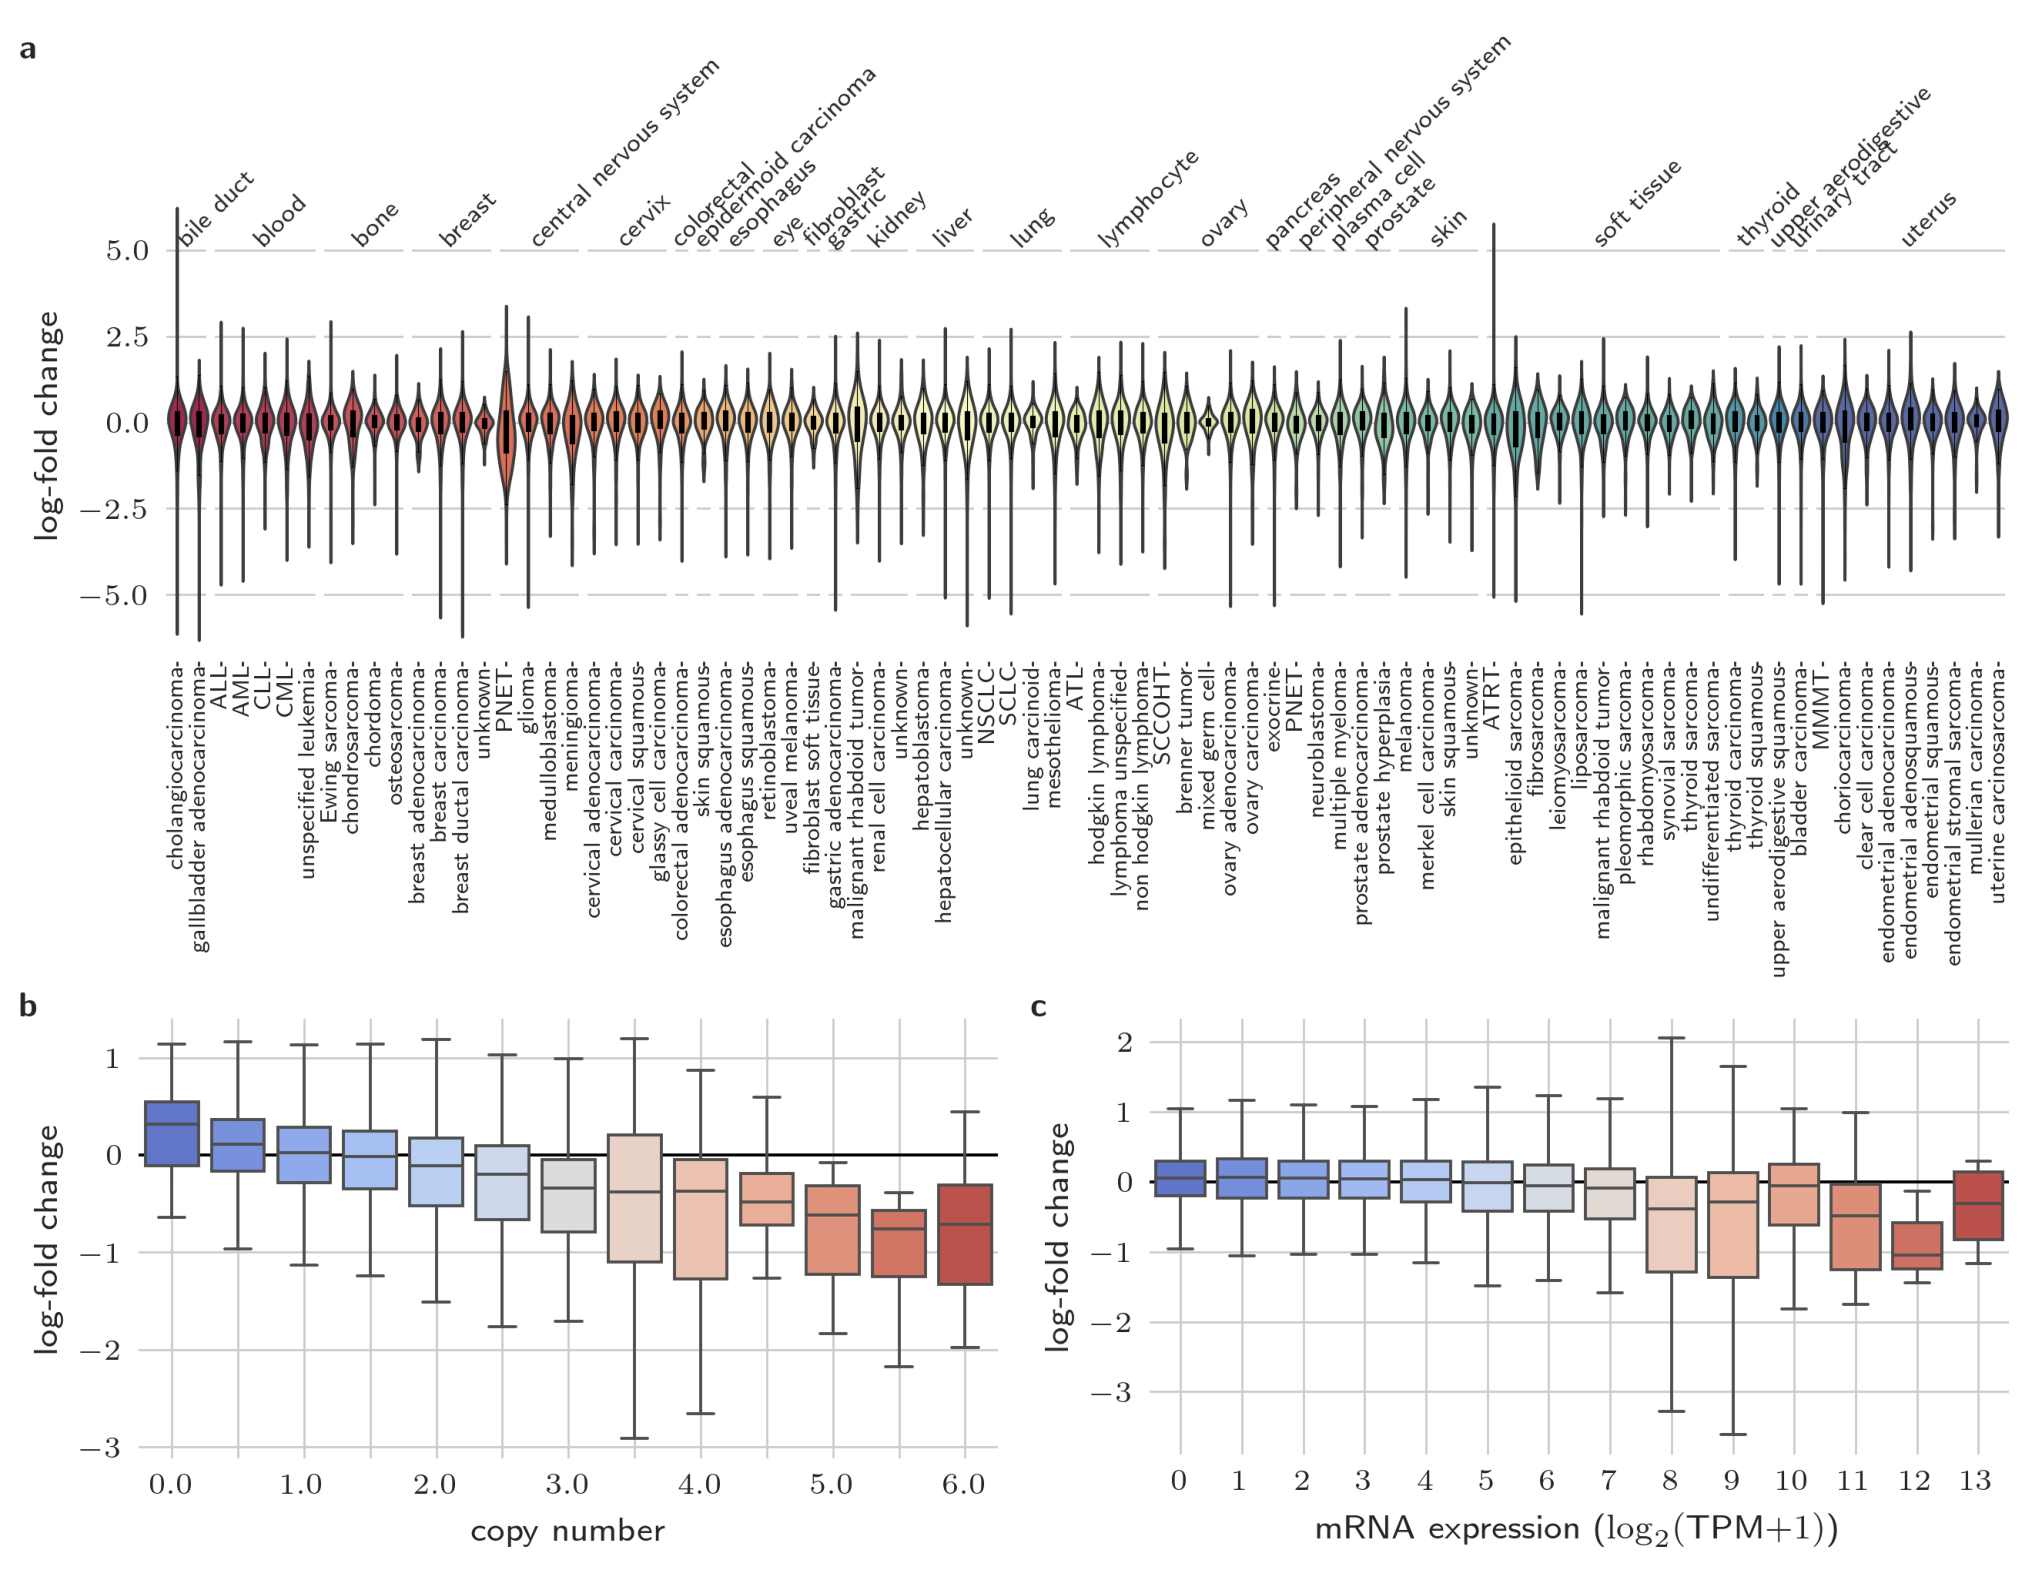

In [23]:
figure
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0)

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [24]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-23

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: figures

matplotlib: 3.5.3
speclet   : 0.0.9000
pandas    : 1.4.4
numpy     : 1.23.3
janitor   : 0.22.0
seaborn   : 0.11.2
dask      : 2022.9.0

